<a href="https://colab.research.google.com/github/NiloufarAsghari/EpilepsyDetection_VGG16/blob/main/seizureDetection_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow.compat.v2 as tf

from keras import backend
from keras.applications import imagenet_utils
from keras.engine import training
from keras.layers import VersionAwareLayers
from keras.utils import data_utils
from keras.utils import layer_utils
from tensorflow.python.util.tf_export import keras_export
import urllib.request
import os
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile
import numpy as np

Mount to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Check and change the directory

In [ ]:
import os
os.chdir('drive') #change directory to drive
os.chdir('MyDrive') #change directory to MyDrive to use Z O N F S files
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

FileNotFoundError: ignored

In [ ]:
print(len(os.listdir('/content/drive/MyDrive/ASeizure_nonSeizure/Seizure')))
print(len(os.listdir('/content/drive/MyDrive/ASeizure_nonSeizure/non_Seizure')))
print(len(os.listdir('/content/drive/MyDrive/AEpilepsyDetection/Test/Seizure/')))
print(len(os.listdir('/content/drive/MyDrive/AEpilepsyDetection/Test/non_Seizure/')))
#It should be 100 and 200
#0,0
#10,20

100
200
10
20


In [ ]:
#Skip
#Me: First check if directory exists then remove it
import os
import shutil

if os.path.exists('/content/drive/MyDrive/EpilepsyDetection/') and os.path.isdir('/content/drive/MyDrive/EpilepsyDetection'):
    shutil.rmtree('/content/drive/MyDrive/EpilepsyDetection')


In [ ]:
#Skip

# Use os.mkdir to create your directories
# You will need a directory for Seizure_non-Seizure, and subdirectories for training
# and testing. These in turn will need subdirectories for 'Seizure' and 'non_Seizure' 
#You can do it directly in Drive


to_create = [
    '/tmp/AEpilepsyDetection',
    '/tmp/AEpilepsyDetection/Test',
    '/tmp/AEpilepsyDetection/Train',
    '/tmp/AEpilepsyDetection/Test/Seizure',
    '/tmp/AEpilepsyDetection/Test/non_Seizure',
    '/tmp/AEpilepsyDetection/Train/Seizure',
    '/tmp/AEpilepsyDetection/Train/non_Seizure'
    
]

for directory in to_create:
    try:
        os.mkdir(directory)
        print(directory, 'created')
    except:
        print(directory, 'failed')

/tmp/AEpilepsyDetection created
/tmp/AEpilepsyDetection/Test created
/tmp/AEpilepsyDetection/Train created
/tmp/AEpilepsyDetection/Test/Seizure created
/tmp/AEpilepsyDetection/Test/non_Seizure created
/tmp/AEpilepsyDetection/Train/Seizure created
/tmp/AEpilepsyDetection/Train/non_Seizure created


In [ ]:
#Skip if it's not the first time
#python Function to split data 
#for example, if SOURCE is Seizure_nonSeizure/Seizure, and SPLIT SIZE is .9
# Then 90% of the images in Seizure_nonSeizure/Seizure will be copied to the TRAINING dir
# and 10% of the images will be copied to the TESTING dir


#OR
#you can use sklearn library and use train_test_split directly without writing any function

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    all_files = []
    
    for file_name in os.listdir(SOURCE):
        file_path = SOURCE + file_name

        if os.path.getsize(file_path):
            all_files.append(file_name)
        else:
            print('{} is zero length, so ignoring'.format(file_name))
    
    n_files = len(all_files)
    split_point = int(n_files * SPLIT_SIZE)
    
    shuffled = random.sample(all_files, n_files)
    
    train_set = shuffled[:split_point]
    test_set = shuffled[split_point:]
    
    for file_name in train_set:
        copyfile(SOURCE + file_name, TRAINING + file_name)
        
    for file_name in test_set:
        copyfile(SOURCE + file_name, TESTING + file_name)

Seizure_SOURCE_DIR = r"/content/drive/MyDrive/ASeizure_nonSeizure/Seizure/"
TRAINING_Seizure_DIR = r"/content/drive/MyDrive/AEpilepsyDetection/Train/Seizure/"
TESTING_Seizure_DIR = r"/content/drive/MyDrive/AEpilepsyDetection/Test/Seizure/"
non_Seizure_SOURCE_DIR = r"/content/drive/MyDrive/ASeizure_nonSeizure/non_Seizure/"
TRAINING_non_Seizure_DIR = r"/content/drive/MyDrive/AEpilepsyDetection/Train/non_Seizure/"
TESTING_non_Seizure_DIR = r"/content/drive/MyDrive/AEpilepsyDetection/Test/non_Seizure/"

split_size = .9
split_data(Seizure_SOURCE_DIR, TRAINING_Seizure_DIR, TESTING_Seizure_DIR, split_size)
split_data(non_Seizure_SOURCE_DIR, TRAINING_non_Seizure_DIR, TESTING_non_Seizure_DIR, split_size)


In [ ]:
print(len(os.listdir('/content/drive/MyDrive/AEpilepsyDetection/Train/Seizure/')))
print(len(os.listdir('/content/drive/MyDrive/AEpilepsyDetection/Train/non_Seizure/')))
print(len(os.listdir('/content/drive/MyDrive/AEpilepsyDetection/Test/Seizure/')))
print(len(os.listdir('/content/drive/MyDrive/AEpilepsyDetection/Test/non_Seizure/')))
#90
#180
#10
#20

90
180
10
20


In [ ]:
"""
trdata=ImageDataGenerator()
#directory: Our dataset divided into test and training
traindata= trdata.flow_from_directory(directory='',target_size=(224,224))
tsdata=ImageDataGenerator()
testdata= trdata.flow_from_directory(directory='',target_size=(224,224))
"""


              #VGG
#VGG=tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=True, weights='imagenet')
#VGG=tf.keras.applications.VGG16(input_shape=(224,224,3), weights='imagenet')


#the entire layers are present inside this. Feature extractor vgg16 is build
#VGG.trainable=False

#we don't want to trian the front 13 layers and we need train only the last two layers

#1 dense 4096
#1 dense 32
#1 dense softmax 2 units // Sigmoid 1 unit 2 classes 



#VGG16 using keras
"""
model= tf.keras.Sequential([
                         VGG,
                         tf.keras.layers.Flatten(),
                         tf.keras.layers.Dense(units=4096,activation='relu'),
                         tf.keras.layers.Dense(units=32,activation='relu'),
                         tf.keras.layers.Dropout(0.5),
                         tf.keras.layers.Dense(units=1,activation='softmax'),                         
])
"""

#adam = optimizers.Adam(lr=0.00002, beta_1=0.9, beta_2=0.999, epsilon=0.00000001, decay=0.0, amsgrad=False)
#using adam optimizer
# learning rate=10^-5 but the original is 10^-3
"""
tf.keras.optimizers.Adam(
    learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam',
)
"""

"""
model.compile(
    #optimizer=RMSprop(lr=0.001),
#    optimizer='adam',
        optimizer='Adam', #Our Customized Adam optimizer writes just lines above
              loss='binary_crossentropy',
              #loss=tf.keras.losses.categorical_crossentropy,
              #metrics=['accuracy'])
              metrics=['acc'])
"""
#evalulate the model

"""
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.TruePositives(),
                         tf.keras.metrics.TrueNegatives(),
                         tf.keras.metrics.FalsePositives(),
                         tf.keras.metrics.FalseNegatives()])

"""
"""


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
"""

#implement VGG16 From scratch

"""
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=512,activation="relu"))
model.add(Dense(units=1, activation="softmax"))   # 1 for 2 class wich is 'Seizure' and 'non-Seizure'


#opt = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
"""

# a simple model. accuracy in bonn dataset = val_acc: 0.9667

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])




#Customized Adam Optimizer
"""
tf.keras.optimizers.Adam(
    learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam',
)
"""

model.compile(
    #optimizer=RMSprop(lr=0.001),
#    optimizer='adam',
       # optimizer='Adam', #Our Customized Adam optimizer writes just lines above
        optimizer='sgd',
           # loss='categorical_crossentropy',
              loss='binary_crossentropy',
              #loss=tf.keras.losses.categorical_crossentropy,
              #metrics=['accuracy'])
              metrics=['acc'])

#model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])


#from keras.optimizers import SGD
#opt = SGD(lr=0.01)
#model.compile(loss = "categorical_crossentropy", optimizer = opt)
#VGG.summary()
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 53, 53, 64)        8256      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 26, 26, 64)      

In [ ]:

#ex
"""
datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=180,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')
"""
#Target size is (224,224)
TRAINING_DIR = '/content/drive/MyDrive/AEpilepsyDetection/Train/'
train_datagen = ImageDataGenerator(rescale=1 / 255,
                                    rotation_range=0.05,
                                   shear_range=0.05,
                                   zoom_range=0.05,
                                   horizontal_flip=True,
                                   vertical_flip=True
                                   )
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=16,
    class_mode='binary',
    target_size=(224, 224)
)

VALIDATION_DIR = '/content/drive/MyDrive/AEpilepsyDetection/Test/'
validation_datagen = ImageDataGenerator(rescale= 1/255)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=16,
    class_mode='binary',
    target_size=(224, 224)
)
#The data-generators will return batches of images. Because the VGG16 model is so large, the batch-size cannot be too large, otherwise you will run out of RAM on the GPU.

#270 2 class
#30 2 class

Found 270 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [ ]:
#Skip
directory='/content/drive/MyDrive/ASeizure_nonSeizure/'
tf.keras.utils.image_dataset_from_directory(
    directory, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(224,
    224), shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 300 files belonging to 2 classes.


<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
history = model.fit_generator(
    train_generator,
    epochs=50,
    verbose=1,
    validation_data=validation_generator
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/50
17/17 [==============================] - 7s 288ms/step - loss: 0.6471 - acc: 0.6370 - val_loss: 0.6399 - val_acc: 0.6667
Epoch 2/50
17/17 [==============================] - 5s 279ms/step - loss: 0.6364 - acc: 0.6667 - val_loss: 0.6221 - val_acc: 0.6667
Epoch 3/50
17/17 [==============================] - 5s 284ms/step - loss: 0.6385 - acc: 0.6667 - val_loss: 0.6176 - val_acc: 0.6667
Epoch 4/50
17/17 [==============================] - 5s 281ms/step - loss: 0.6246 - acc: 0.6667 - val_loss: 0.6158 - val_acc: 0.6667
Epoch 5/50
17/17 [==============================] - 5s 300ms/step - loss: 0.6196 - acc: 0.6704 - val_loss: 0.6074 - val_acc: 0.6667
Epoch 6/50
17/17 [==============================] - 5s 317ms/step - loss: 0.6126 - acc: 0.6667 - val_loss: 0.5934 - val_acc: 0.6667
Epoch 7/50
17/17 [==============================] - 5s 279ms/step - loss: 0.6108 - acc: 0.6704 - val_loss: 0.5803 - val_acc: 0.6667
Epoch 8/50
17/17 [==============================] - 5s 275ms/step - loss: 0.

Text(0.5, 1.0, 'Training and validation loss')

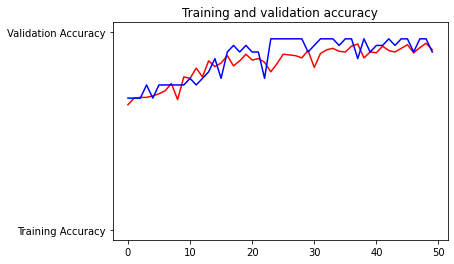

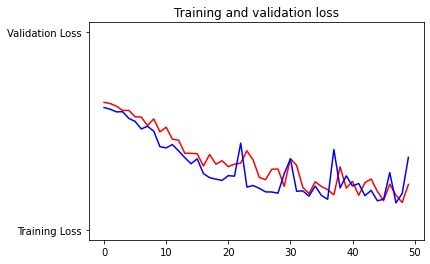

In [ ]:

%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) 


plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

